In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from numpy import *
from numpy.fft import fft,ifft,rfft,irfft
from scipy import signal as sig

In [5]:
st=1158818717
dur=300

data=TimeSeries.get('L1:GDS-CALIB_STRAIN',st,st+dur)

In [6]:
def fir_filter(tsdata, filter_taps):
    srate=tsdata.sample_rate.value
    # Extend filter with zeros to length of data
    filt=zeros(len(tsdata),dtype=tsdata.dtype)
    filt[:len(filter_taps)]=filter_taps.copy()
    # FFT the filter and data, multiply, then IFFT
    # This is the efficient way to convolve them
    # Take abs of filter to make it zero-phase
    result=irfft(abs(rfft(filt))*rfft(tsdata.value))
    # Remove beginning and end of data corrupted by
    # filter transient. Round up to integer seconds.
    halflensec=ceil(len(filter_taps)/srate/2.)
    corrupt_idx=int(halflensec*srate)
    result = TimeSeries(result, sample_rate=srate,
                          epoch=tsdata.epoch)
    return result[corrupt_idx:-corrupt_idx]

As of this writing, the L1 h(t) data has a very large dynamic range at low frequencies. We need to remove this before doing anything.

In [10]:
data_dt=1.e20*data.astype(float64).detrend()
filt=sig.firwin(int(8*srate)-1,9./nyquist,pass_zero=False,window='hann')
data_hp=fir_filter(data_dt,filt)

Below are three options for bandpasses.

The first one isolates the caduceus lines, and also notches the 60 Hz and 180 Hz which are very close.

The second one is similar, but removes the first harmonic to give a clearer sound from the ones that more audible.

The third just isolates the violin modes.

In [11]:
freqs=[52,59.8,60.2,64,112,124,171,179.5,180.5,183,230,242]
#freqs=[110,124,171,179.5,180.5,183,230,242]
#freqs=[480,530,980,1040,1460,1530]

In [12]:
srate=data.sample_rate.value
nyquist=srate/2.
filt=sig.firwin(32*srate,[ff/nyquist for ff in freqs],pass_zero=False,window='hann')
data_bp=fir_filter(data_hp,filt)

In [14]:
from scipy.io import wavfile
output=data_bp.value[int(16*srate):int(46*srate)]
output=output/max(abs(output))
wavfile.write('fir_bp_caduceus.wav',rate=srate,data=output)

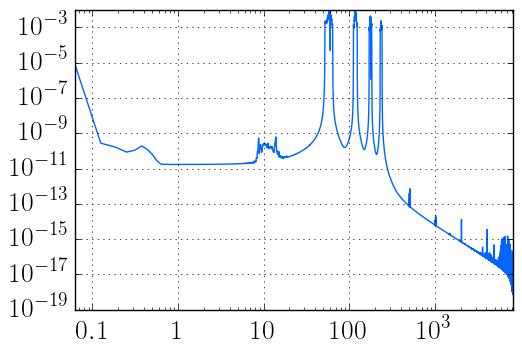

In [15]:
p1=data_bp.asd(16,12).plot()